### Imports & Constants:

In [10]:
%matplotlib inline

import os
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sb

import matplotlib.pyplot as plt

from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext

from IPython.display import clear_output

print 'appName[%s] master[%s] env[%s] sparkHome[%s] version[%s]' % (sc.appName, sc.master, sc.environment, sc.sparkHome, sc.version)

socket_stream_host = 'ec2-52-90-85-86.compute-1.amazonaws.com' # spark host
cassandra_host = 'ec2-52-90-58-65.compute-1.amazonaws.com' # cassandra host
socket_stream_port = 9999 # port# to stream into
checkpoint_dir = '/checkpoint' 
output_dir = '/output'

def createStreamRDD(batch_interval=None):
    ''' create streaming context with batch size x seconds, for every new run. '''
    batch_interval = batch_interval or 30
    ssc = StreamingContext(sc, batch_interval)
    ssc.checkpoint(checkpoint_dir)
    return ssc, ssc.socketTextStream(socket_stream_host, socket_stream_port)

appName[PySparkShell] master[spark://ip-172-31-59-31:7077] env[{}] sparkHome[None] version[1.4.1]


### Function Definitions

In [11]:
# Reusable Lambdas...
adder = lambda x,y: x+y
divider = lambda pair: pair[0] / float(pair[1])
pipe_split = lambda line : line.split('|')
pair_adder = lambda x,y: (x[0]+y[0], x[1]+y[1])

### Below Methods are used by updateStateByKey. ###
# value accumulator per key -> (key, 1)
def accumulator(new_counts, old_sum):
    ''' value accumulator per key -> (key, 1) '''
    return sum(new_counts) + (old_sum or 0)

# pair value accumulator per key -> (key, (value, 1))
def pair_accumulator(new_pairs, old_pair):
    ''' pair value accumulator per key -> (key, (value, 1)) '''
    # new_pairs -> (total delay, total count)
    if old_pair:
        total_delay, count = (old_pair[0] or 0), (old_pair[1] or 0)
    else:
        total_delay, count = 0, 0
    
    for new_pair in new_pairs:
        if new_pair:
            total_delay += (new_pair[0] or 0)
            count += (new_pair[1] or 0)
    
    return (total_delay, count)

def processRDD(time, rdd, output_subdir, plotf=None):
    ''' For each RDD Processor, prints interim RDD info/output/plots '''
    
    if rdd.isEmpty():
        return
    
    print('=============== [%s], RDD Size [%s] ===============' % (str(time), rdd.count()))
    if plotf:
        plotf(rdd)
    else:
        print(rdd.take(10))
    rdd.coalesce(1).saveAsTextFile(os.path.join(output_dir, output_subdir))
    print('=========================================================================')

### [BATCH] Read .PSV files from HDFS
### Each line is composed of the following 17 fields in following order:
   - 0: year
   - 1: month
   - 2: dayofmonth
   - 3: dayofweek
   - 4: flight_date
   - 5: unique_carrier
   - 6: flightNum
   - 7: origin
   - 8: dest
   - 9: crs_dep_time  
   - 10: dep_delay_min
   - 11: dep_del_15
   - 12: crs_arr_time
   - 13: arr_delay_min
   - 14: arr_del_15 
   - 15: cancelled
   - 16: diverted   

In [4]:
ontimeRDD = sc.textFile('hdfs://ec2-52-90-85-86.compute-1.amazonaws.com:9000/input/ontime_all.psv')

In [16]:
ontimeRDD = sc.textFile('hdfs://ec2-52-90-85-86.compute-1.amazonaws.com:9000/input/ontime_2008.psv')

In [3]:
ontimeRDD.take(1)

[u'2008|1|3|4|2008-01-03|WN|588|HOU|LIT|1325|18|1|1435|16|1|0|0']

### [Group1.1 Batch] Rank the Airports by numbers of [to/from] flights

In [3]:
# Rank Airport by # of [to/from] flights.
ontimeRDD.map(pipe_split) \
        .flatMap(lambda fields: [ (fields[7], 1), (fields[8], 1) ]) \
        .reduceByKey(adder) \
        .sortBy(lambda x: x[1], ascending=False).collect()

[(u'ATL', 681131),
 (u'ORD', 569212),
 (u'DFW', 461573),
 (u'DEN', 400649),
 (u'LAX', 362699),
 (u'PHX', 333226),
 (u'IAH', 306159),
 (u'LAS', 290540),
 (u'DTW', 270080),
 (u'SLC', 232159),
 (u'SFO', 232022),
 (u'EWR', 227606),
 (u'MSP', 218645),
 (u'MCO', 217874),
 (u'CLT', 207864),
 (u'JFK', 194508),
 (u'BOS', 193992),
 (u'LGA', 192796),
 (u'SEA', 183856),
 (u'BWI', 173552),
 (u'PHL', 165461),
 (u'SAN', 157428),
 (u'CVG', 153386),
 (u'MDW', 146569),
 (u'DCA', 140898),
 (u'MEM', 133831),
 (u'TPA', 130210),
 (u'IAD', 125049),
 (u'FLL', 111137),
 (u'CLE', 110315),
 (u'OAK', 105683),
 (u'STL', 104000),
 (u'MIA', 102562),
 (u'MCI', 99964),
 (u'RDU', 99758),
 (u'PDX', 97297),
 (u'SJC', 95855),
 (u'BNA', 95373),
 (u'HNL', 93083),
 (u'HOU', 91012),
 (u'SMF', 89904),
 (u'DAL', 89226),
 (u'AUS', 83528),
 (u'SNA', 78624),
 (u'SAT', 75926),
 (u'IND', 71456),
 (u'MKE', 70379),
 (u'PIT', 69770),
 (u'ABQ', 69232),
 (u'MSY', 64721),
 (u'ONT', 60898),
 (u'CMH', 56608),
 (u'JAX', 54479),
 (u'BUR', 522

In [3]:
# Rank Airport by # of [to/from] flights.
result = ontimeRDD.map(pipe_split) \
        .flatMap(lambda fields: [ (fields[7], 1), (fields[8], 1) ]) \
        .reduceByKey(adder) \
        .sortBy(lambda x: x[1], ascending=False).collect()
airport_rank_df = pd.DataFrame(result, columns=['airport', 'traffic'])
print airport_rank_df[:20]

   airport  traffic
0      ATL   681131
1      ORD   569212
2      DFW   461573
3      DEN   400649
4      LAX   362699
5      PHX   333226
6      IAH   306159
7      LAS   290540
8      DTW   270080
9      SLC   232159
10     SFO   232022
11     EWR   227606
12     MSP   218645
13     MCO   217874
14     CLT   207864
15     JFK   194508
16     BOS   193992
17     LGA   192796
18     SEA   183856
19     BWI   173552

[20 rows x 2 columns]


### [Group1.1 Streaming] Rank the Airports by numbers of [to/from] flights
### Prepare New Socket Streamer with batch every 15 seconds.

In [18]:
ssc, streamRDD = createStreamRDD(15)

### Start Streaming... 

### Spark Streaming consists of micro batches. Each batch will accumulate Airport Traffic counts and generate latest status graph.

=============== [2016-02-22 06:30:45], RDD Size [236] ===============


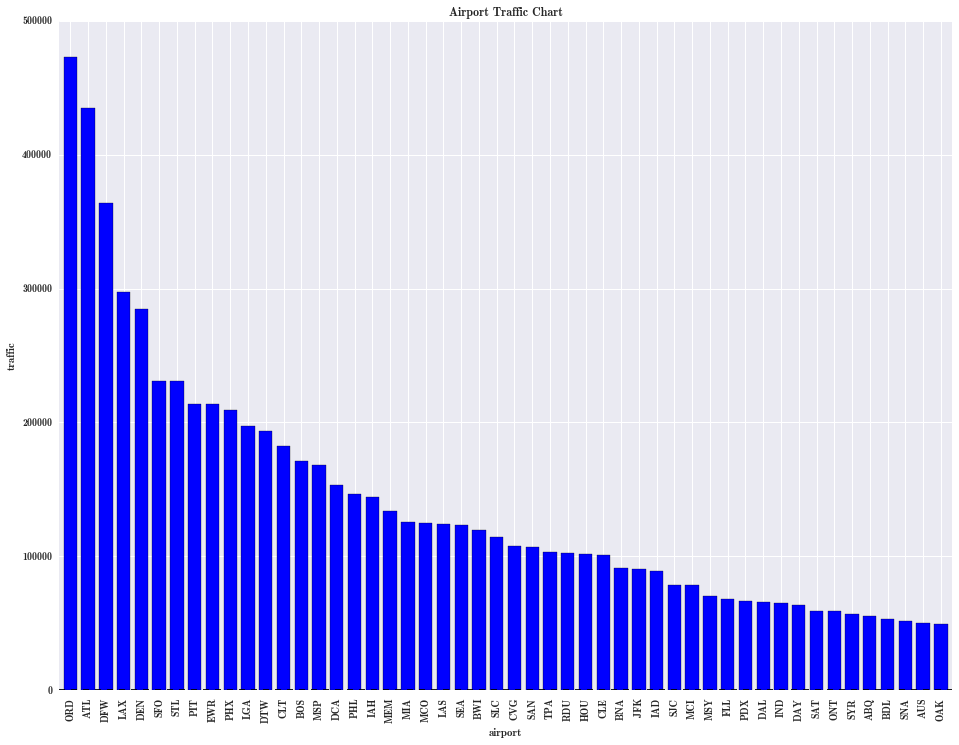

=============== [2016-02-22 06:31:00], RDD Size [243] ===============


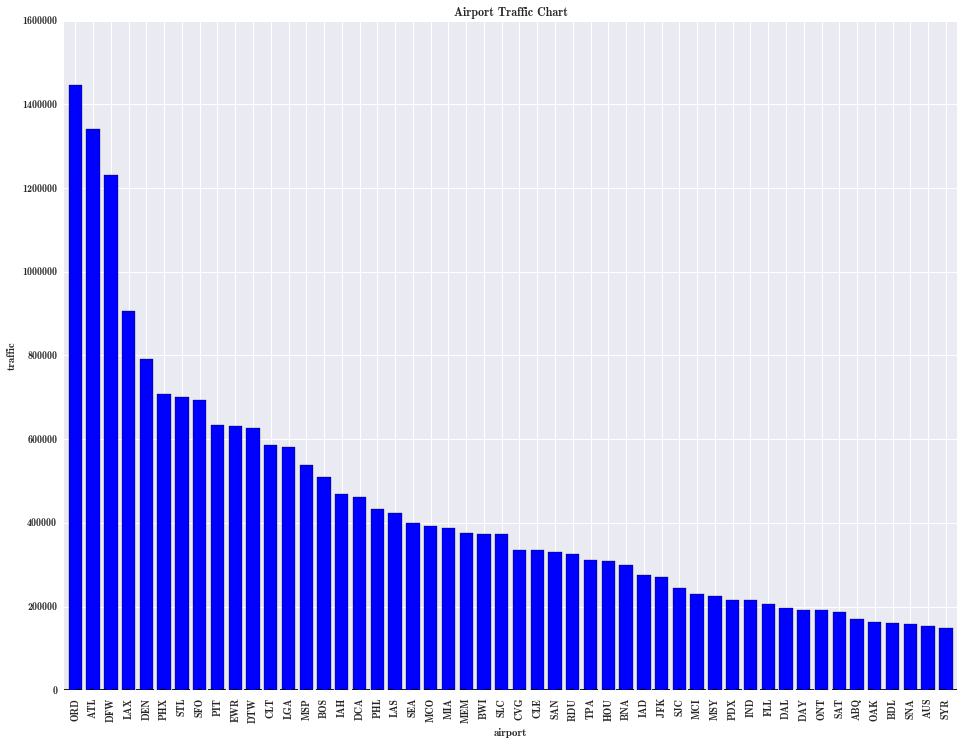

=============== [2016-02-22 06:31:15], RDD Size [249] ===============


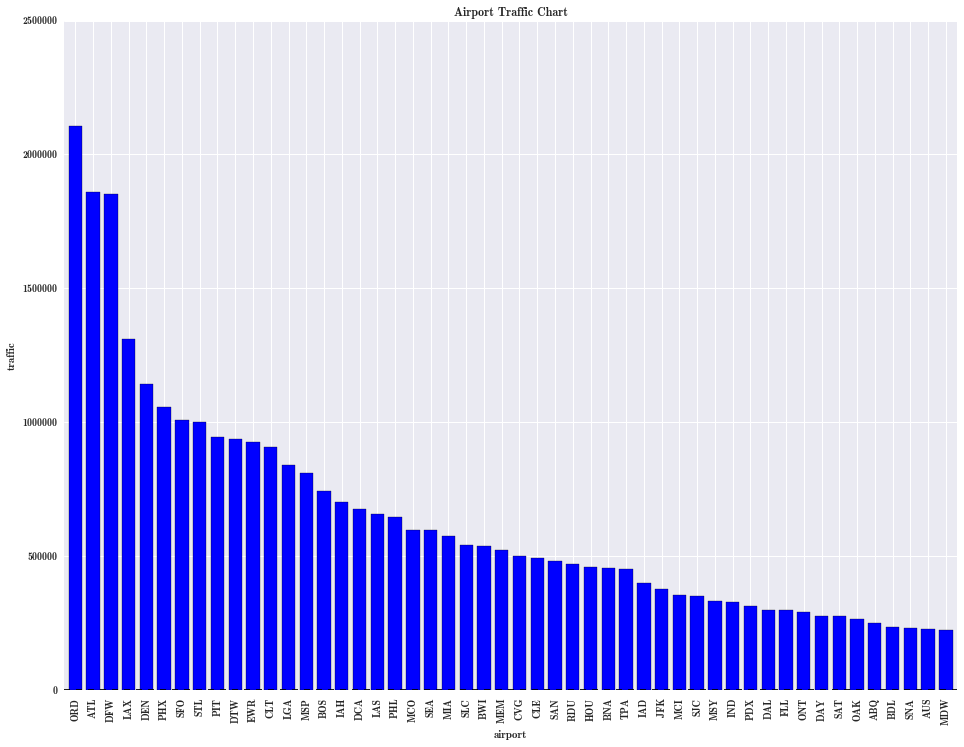

=============== [2016-02-22 06:31:30], RDD Size [257] ===============


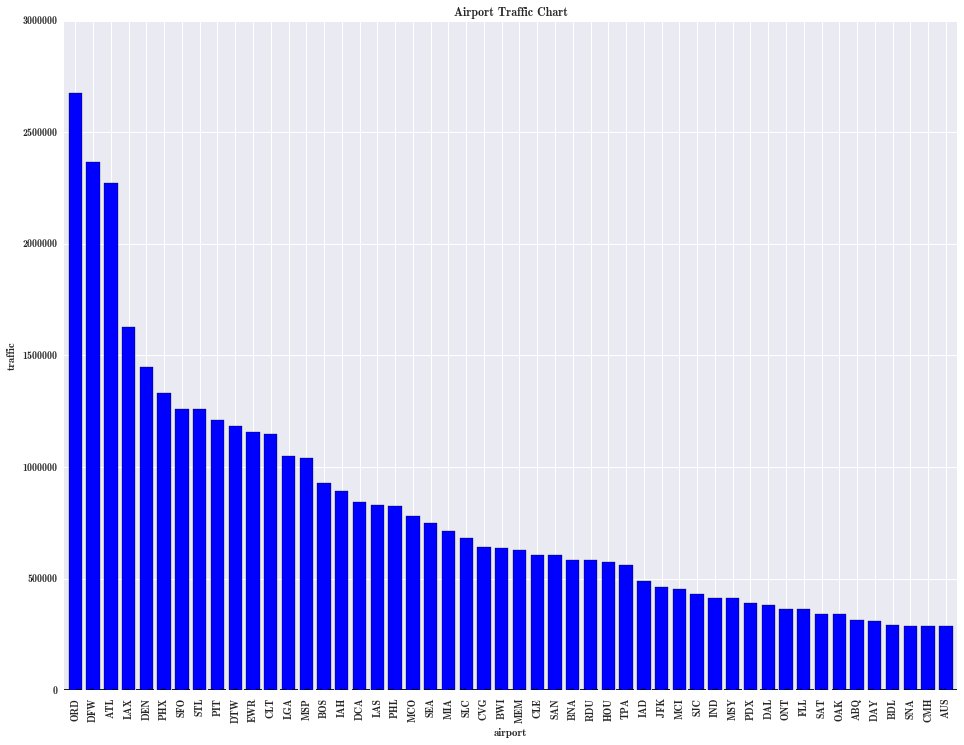

=============== [2016-02-22 06:31:45], RDD Size [261] ===============


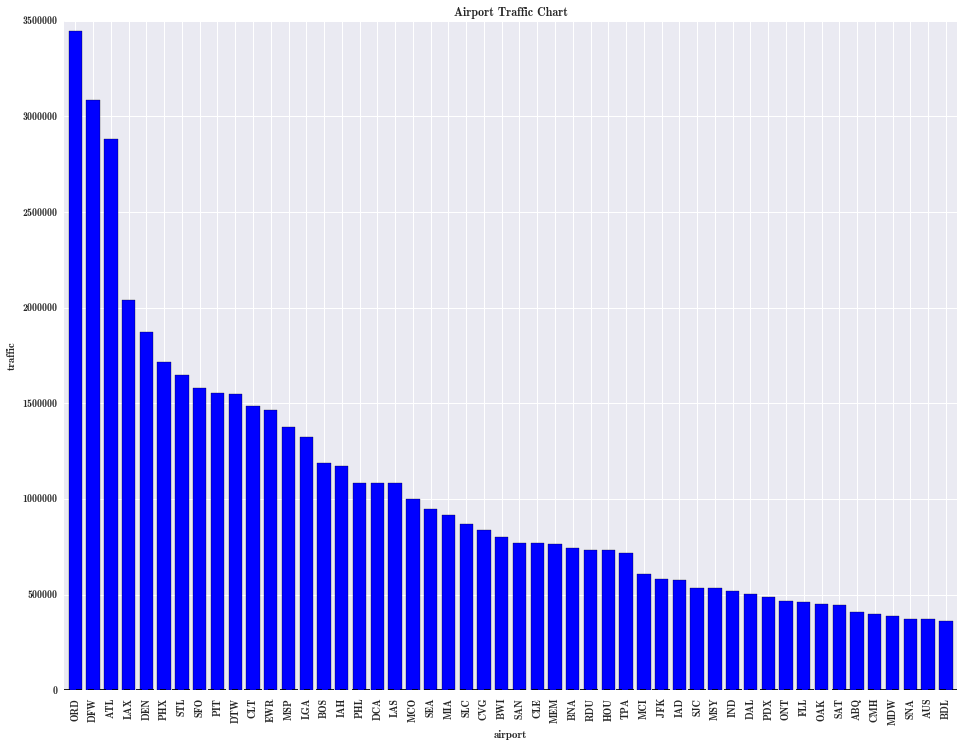

In [19]:
def airport_rank_plot(rdd):
    # create dataframe first before to minimize fresh rendering time.
    airport_rank_df = pd.DataFrame(rdd.collect(), columns=['airport', 'traffic'])
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,12))
    ax.set_xlabel('airport')
    ax.set_ylabel('traffic')
    ax.set_title('Airport Traffic Chart')
#     ax.clear() # clear any previous plots..
    airport_rank_df['traffic'][:50].plot(kind='bar')
    ax.set_xticklabels(airport_rank_df['airport'][:50])
    plt.show()

airport_ranks = streamRDD.map(pipe_split) \
                .flatMap(lambda fields: [ (fields[7], 1), (fields[8], 1) ]) \
                .reduceByKey(adder) \
                .updateStateByKey(accumulator) \
                .transform(lambda rdd: rdd.sortBy(lambda x: x[1], ascending=False))

airport_ranks.foreachRDD(lambda time, rdd: processRDD(time, rdd, output_subdir='airport_rank', plotf=airport_rank_plot))

ssc.start()

### Stop Streaming

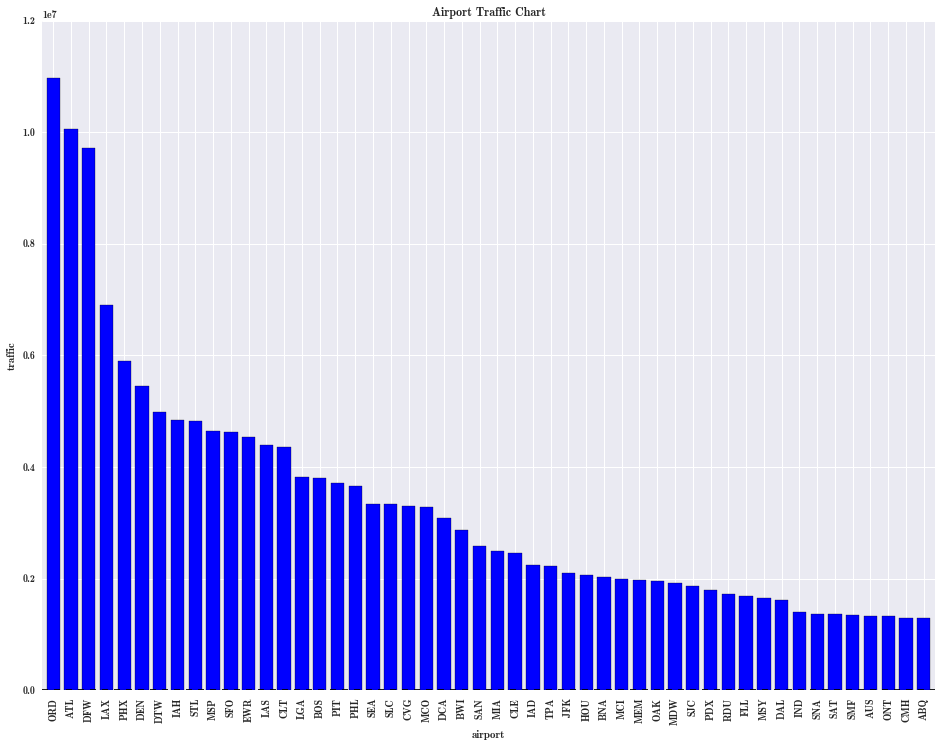

=============== [2016-02-22 06:14:45], RDD Size [335] ===============


In [12]:
# stop the streaming
ssc.stop(stopSparkContext=False)

### [Group 1.2 Batch] Rank the Airlines by on-time arrival performance(min)

In [17]:
# Rank Airlines by average on-time arrival performances
ontimeRDD.map(pipe_split) \
        .map(lambda fields: (fields[5], (int(fields[13]), 1) ) ) \
        .reduceByKey(pair_adder) \
        .mapValues(divider) \
        .sortBy(lambda x: x[1], ascending=True).collect()

[(u'AQ', 2.989422084623323),
 (u'HA', 4.919520271361654),
 (u'9', 8.423296543266652),
 (u'F9', 9.5144056289347),
 (u'WN', 10.050195347381221),
 (u'US', 10.291546198531487),
 (u'AS', 10.661352196551372),
 (u'OO', 11.725730127419096),
 (u'NW', 12.780191082372179),
 (u'DL', 12.787615768801823),
 (u'9E', 13.083866421909477),
 (u'FL', 14.09516415668169),
 (u'MQ', 15.055293795336691),
 (u'EV', 15.439812899320149),
 (u'CO', 15.928224233315213),
 (u'XE', 16.34696340244738),
 (u'OH', 16.738241964258716),
 (u'YV', 16.829953961715532),
 (u'UA', 18.134352433249667),
 (u'B6', 18.31003967043027),
 (u'AA', 18.421851424693337)]

### [Group 1.2 Streaming] Rank the Airlines by on-time arrival performance(min)

In [22]:
ssc, streamRDD = createStreamRDD(15)

=============== [2016-02-21 04:54:00], RDD Size [14] ===============


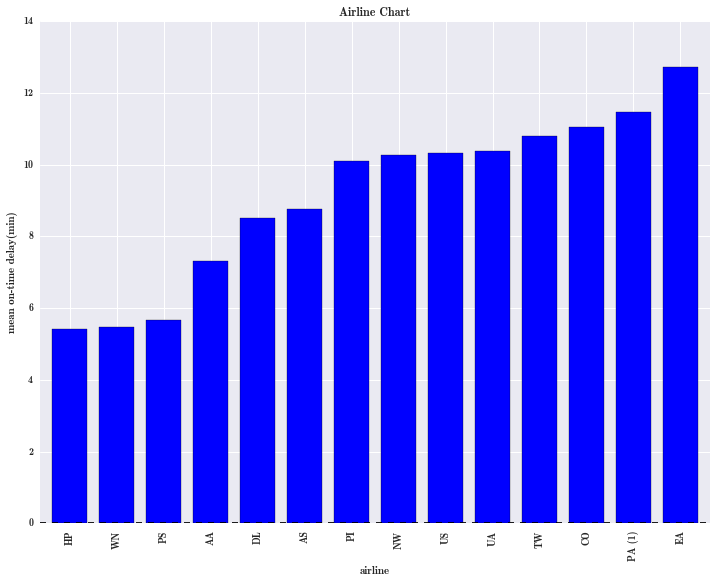

=============== [2016-02-21 04:54:15], RDD Size [14] ===============


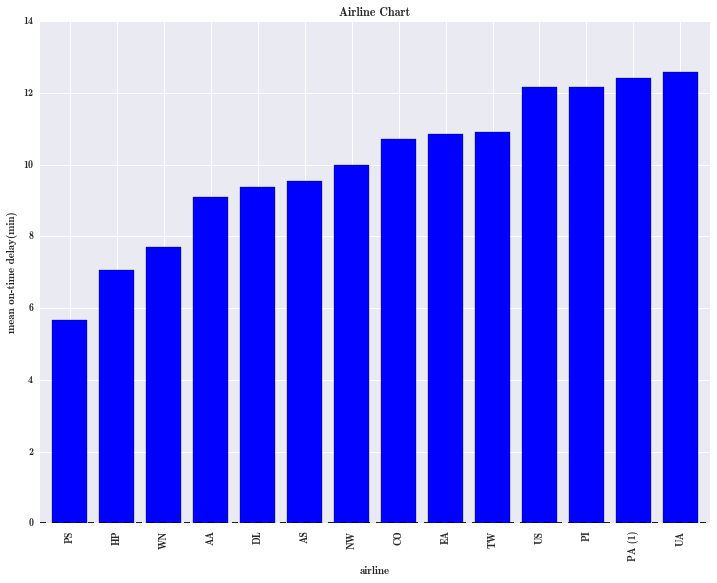

=============== [2016-02-21 04:54:30], RDD Size [14] ===============


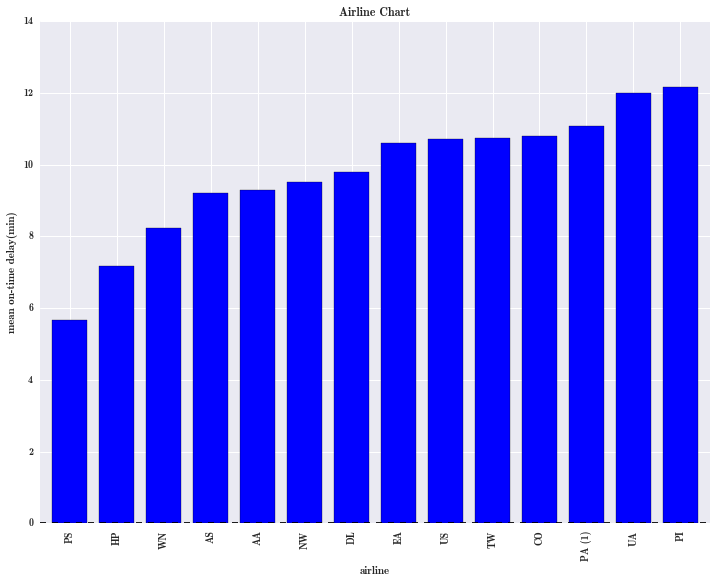

=============== [2016-02-21 04:54:45], RDD Size [15] ===============


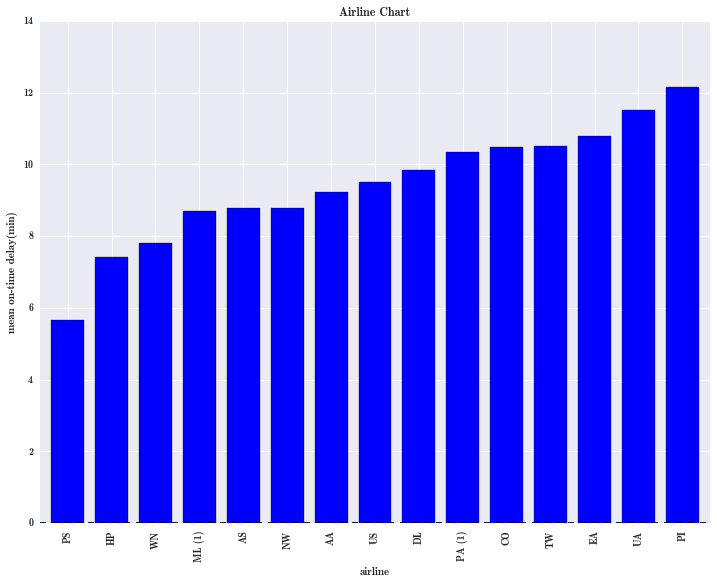

=============== [2016-02-21 04:55:00], RDD Size [15] ===============


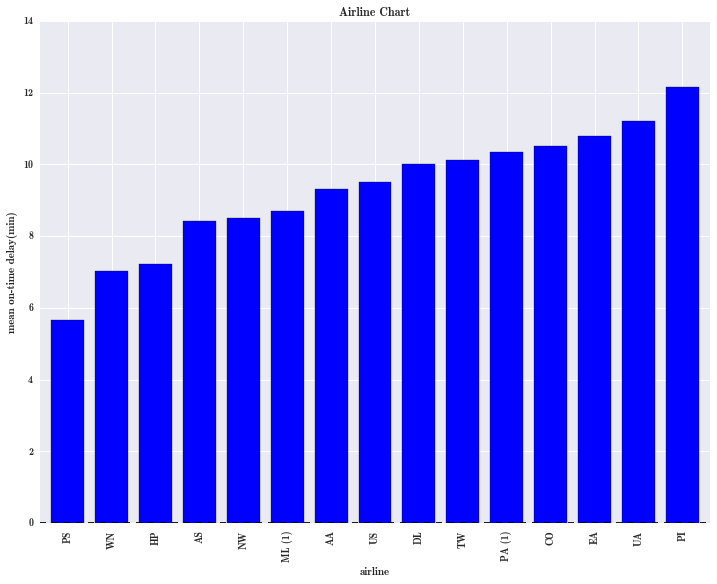

=============== [2016-02-21 04:55:15], RDD Size [15] ===============


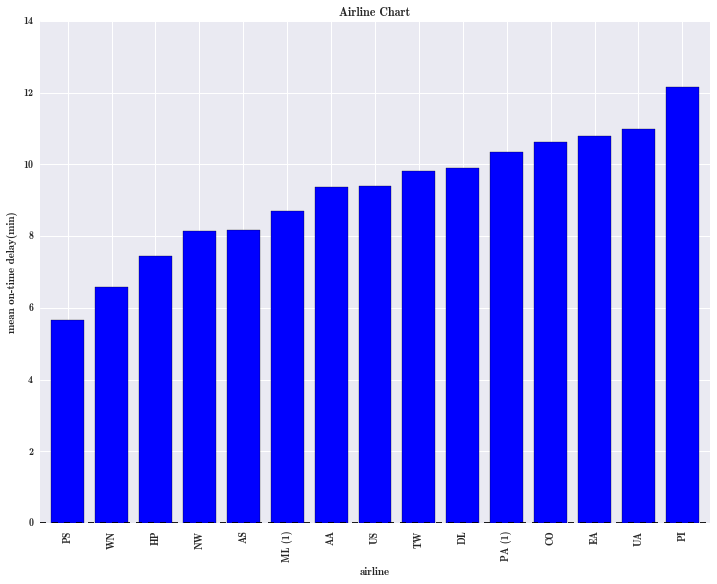

=============== [2016-02-21 04:55:30], RDD Size [15] ===============


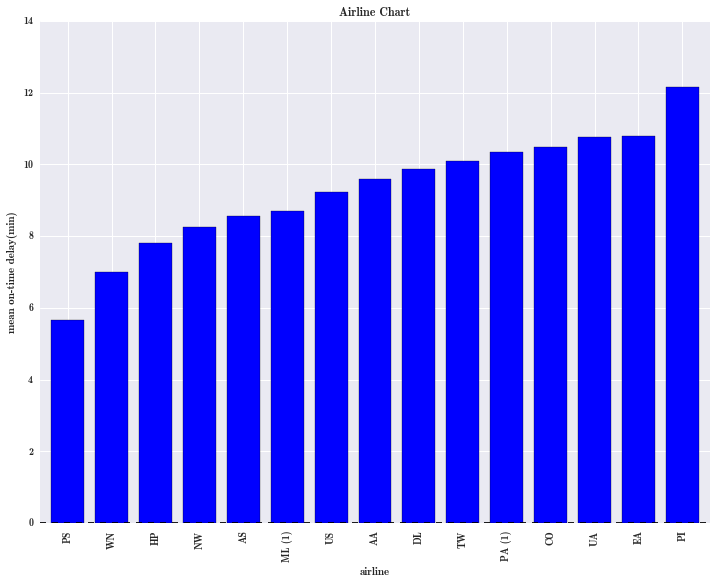

=============== [2016-02-21 04:55:45], RDD Size [15] ===============


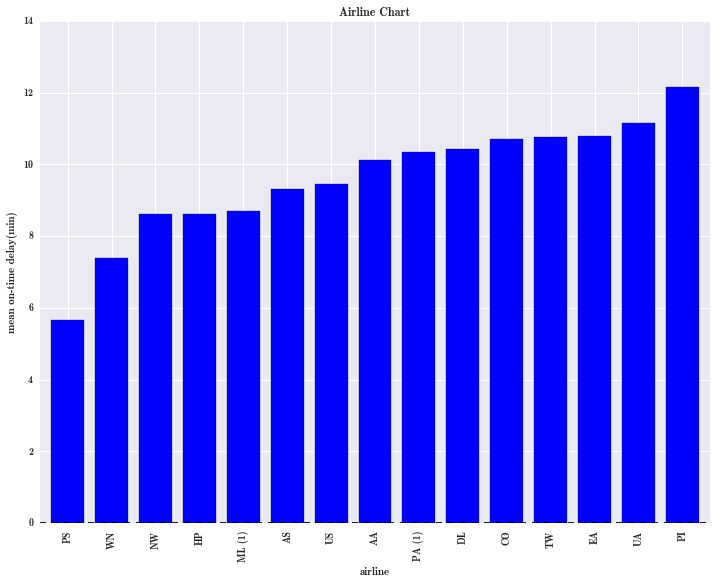

=============== [2016-02-21 04:56:00], RDD Size [15] ===============


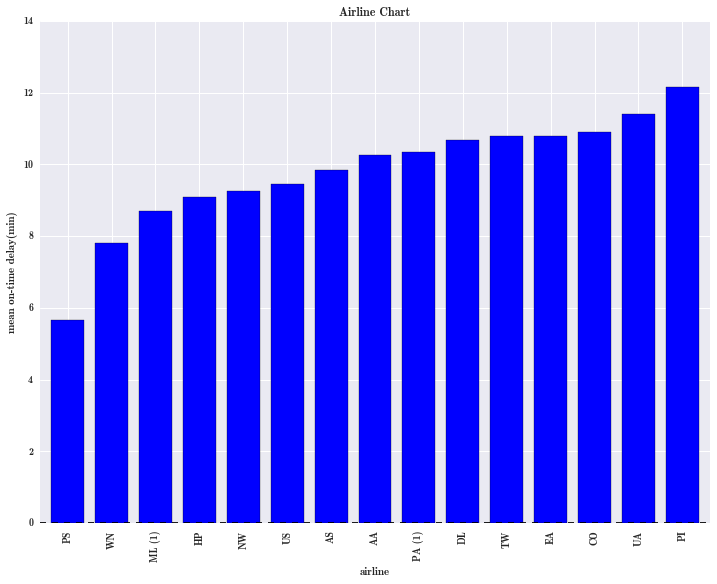

=============== [2016-02-21 04:56:15], RDD Size [15] ===============


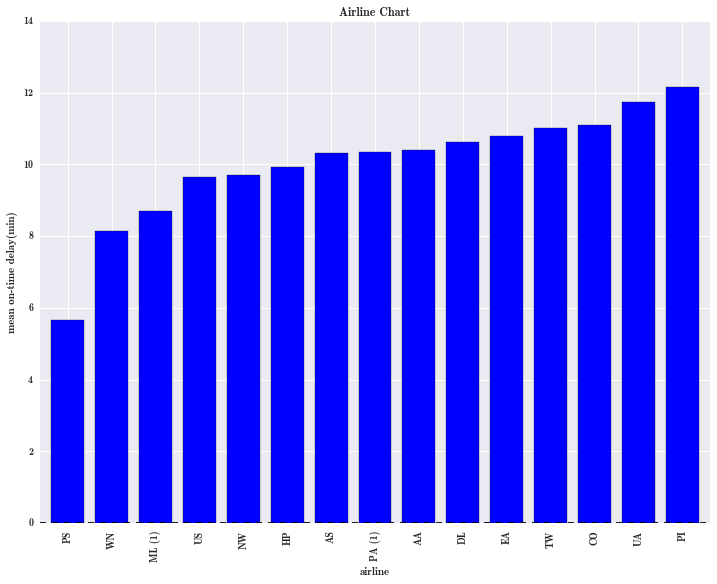

=============== [2016-02-21 04:56:30], RDD Size [15] ===============


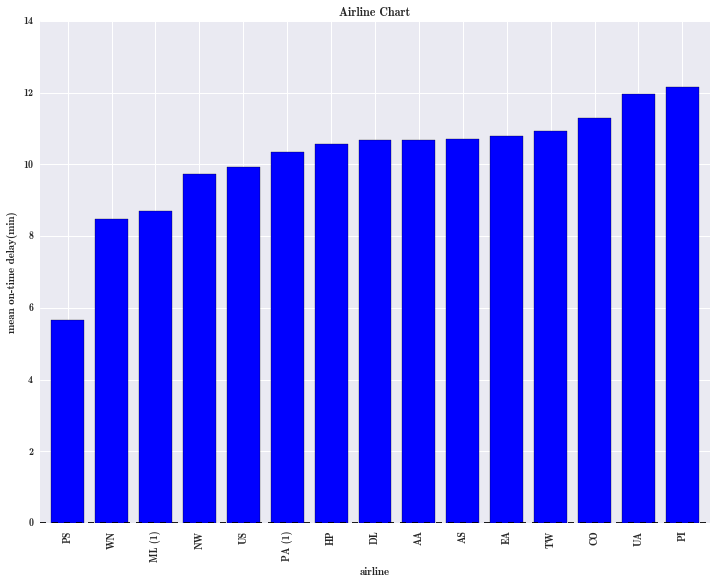

=============== [2016-02-21 04:56:45], RDD Size [17] ===============


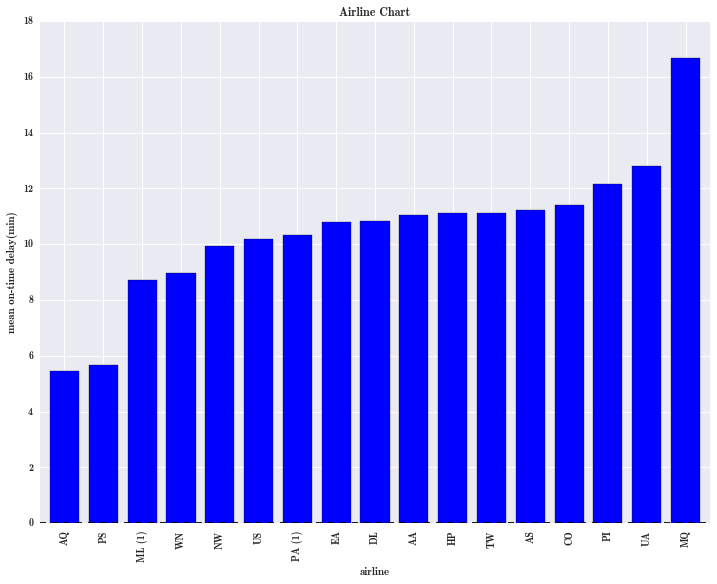

=============== [2016-02-21 04:57:00], RDD Size [19] ===============


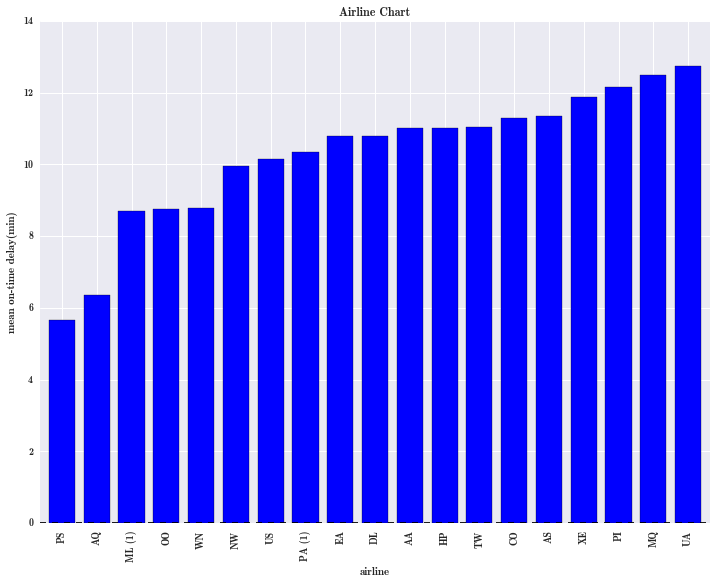

Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/streaming/util.py", line 57, in call
    r = self.func(t, *rdds)
  File "/usr/local/spark/python/pyspark/streaming/dstream.py", line 616, in <lambda>
    self.func = lambda t, rdd: func(t, prev_func(t, rdd))
  File "/usr/local/spark/python/pyspark/streaming/dstream.py", line 295, in <lambda>
    func = lambda t, rdd: oldfunc(rdd)
  File "<ipython-input-23-4d4a06cf9001>", line 14, in <lambda>
    airline_ranks = streamRDD.map(pipe_split)                         .map(lambda fields: (fields[5], (int(fields[13]), 1) ) )                         .reduceByKey(pair_adder)                         .updateStateByKey(pair_accumulator)                         .mapValues(divider)                         .transform(lambda rdd: rdd.sortBy(lambda x: x[1], ascending=True))
  File "/usr/local/spark/python/pyspark/rdd.py", line 660, in sortBy
    return self.keyBy(keyfunc).sortByKey(ascending, numPartitions).values()
  File "/usr/l

In [23]:
def airline_rank_plot(rdd):
    # create dataframe first before to minimize fresh rendering time.
    airline_rank_df = pd.DataFrame(rdd.collect(), columns=['airline', 'delay'])
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,9))
    ax.set_xlabel('airline')
    ax.set_ylabel('mean on-time delay(min)')
    ax.set_title('Airline Chart')

    airline_rank_df['delay'][:25].plot(kind='bar')
    ax.set_xticklabels(airline_rank_df['airline'][:25])
    plt.show()
    
airline_ranks = streamRDD.map(pipe_split) \
                        .map(lambda fields: (fields[5], (int(fields[13]), 1) ) ) \
                        .reduceByKey(pair_adder) \
                        .updateStateByKey(pair_accumulator) \
                        .mapValues(divider) \
                        .transform(lambda rdd: rdd.sortBy(lambda x: x[1], ascending=True))
                
airline_ranks.foreachRDD(lambda time, rdd: processRDD(time, rdd, output_subdir='airline_rank', plotf=airline_rank_plot))

ssc.start()

In [24]:
# stop the streaming
ssc.stop(stopSparkContext=False)

    r = self.func(t, *rdds)
  File "/usr/local/spark/python/pyspark/streaming/dstream.py", line 616, in <lambda>
    self.func = lambda t, rdd: func(t, prev_func(t, rdd))
  File "/usr/local/spark/python/pyspark/streaming/dstream.py", line 295, in <lambda>
    func = lambda t, rdd: oldfunc(rdd)
  File "<ipython-input-23-4d4a06cf9001>", line 14, in <lambda>
    airline_ranks = streamRDD.map(pipe_split)                         .map(lambda fields: (fields[5], (int(fields[13]), 1) ) )                         .reduceByKey(pair_adder)                         .updateStateByKey(pair_accumulator)                         .mapValues(divider)                         .transform(lambda rdd: rdd.sortBy(lambda x: x[1], ascending=True))
  File "/usr/local/spark/python/pyspark/rdd.py", line 660, in sortBy
    return self.keyBy(keyfunc).sortByKey(ascending, numPartitions).values()
  File "/usr/local/spark/python/pyspark/rdd.py", line 628, in sortByKey
    rddSize = self.count()
  File "/usr/local/spark/py

### [Group 2.1 Batch] Rank each Airlines by on-time departure performance(min) per Airport.

In [11]:
# Rank Airlines by average on-time departure performances for each Airports.
# field 5:carrier, 7:airport, 10:departure delay min.
ontimeRDD.map(pipe_split) \
        .map(lambda fields: ( (fields[7], fields[5]), (int(fields[10]), 1) ) ) \
        .reduceByKey(pair_adder) \
        .mapValues(divider) \
        .map(lambda (key, avg_delay): ( key[0], [(key[1], avg_delay)] )) \
        .reduceByKey(adder) \
        .mapValues(lambda x: sorted(x, key=lambda x: x[1])).collect()

[(u'GSP',
  [(u'9', 7.088888888888889),
   (u'DL', 8.35068493150685),
   (u'OO', 8.560137457044673),
   (u'OH', 8.775745909528393),
   (u'EV', 9.572243346007605),
   (u'9E', 9.573825503355705),
   (u'MQ', 10.296703296703297),
   (u'XE', 15.900392541707557),
   (u'YV', 28.45427135678392)]),
 (u'FNT',
  [(u'NW', 3.9555741827326067),
   (u'OO', 4.904516129032258),
   (u'FL', 8.1296813862493),
   (u'9', 8.776960784313726),
   (u'9E', 10.470108695652174),
   (u'EV', 12.065368567454799),
   (u'MQ', 13.26157237325496)]),
 (u'SIT', [(u'AS', 12.24350940017905)]),
 (u'OAJ', [(u'EV', 11.127777777777778)]),
 (u'BGR',
  [(u'9', 6.484419263456091),
   (u'OH', 10.214070351758794),
   (u'9E', 14.175548589341693),
   (u'EV', 26.5703125),
   (u'XE', 32.18092909535452)]),
 (u'EGE',
  [(u'YV', 10.156828193832599),
   (u'DL', 15.175),
   (u'UA', 17.160377358490567),
   (u'CO', 23.104712041884817),
   (u'US', 26.615384615384617),
   (u'NW', 28.456521739130434),
   (u'AA', 34.74)]),
 (u'PIT',
  [(u'9', 5.786

### [Group 2.1 Streaming] Rank each Airlines by on-time departure performance(min) per Airport.

In [22]:
ssc, streamRDD = createStreamRDD(15)

In [15]:
# Rank Airlines by average on-time departure performances for each Airports.
# field 5:carrier, 7:airport, 10:departure delay min.
airline_rank_per_airport = streamRDD.map(pipe_split) \
                                    .map(lambda fields: ( (fields[7], fields[5]), (int(fields[10]), 1) ) ) \
                                    .reduceByKey(pair_adder) \
                                    .updateStateByKey(pair_accumulator) \
                                    .mapValues(divider) \
                                    .map(lambda (key, avg_delay): ( key[0], [(key[1], avg_delay)] )) \
                                    .reduceByKey(adder) \
                                    .mapValues(lambda x: sorted(x, key=lambda x: x[1]))
        
airline_rank_per_airport.foreachRDD(lambda time, rdd: processRDD(time, rdd, output_subdir='airline_rank_per_airport'))

ssc.start()

NameError: name 'streamRDD' is not defined

In [18]:
# stop the streaming
ssc.stop(stopSparkContext=False)

### [Group 2.2 Batch] Rank each Airports by on-time departure performanc(min) per Airport.

In [12]:
# Rank destination Airports by average on-time departure performances for each airports.
# field 7:origin, 8:destination, 10:departure delay min.
ontimeRDD.map(pipe_split) \
        .map(lambda fields: ( (fields[7], fields[8]), (int(fields[10]), 1) ) ) \
        .reduceByKey(pair_adder) \
        .mapValues(lambda pair: pair[0] / float(pair[1]) ) \
        .map(lambda (key, avg_delay): ( key[0], [(key[1], avg_delay)] )) \
        .reduceByKey(adder) \
        .mapValues(lambda x: sorted(x, key=lambda x: x[1])).collect()

[(u'GSP',
  [(u'CLT', 0.0),
   (u'CVG', 4.7984886649874054),
   (u'DTW', 7.615984405458089),
   (u'DFW', 8.598627787307032),
   (u'MEM', 8.823462414578588),
   (u'ATL', 8.861410381978452),
   (u'IAH', 8.906290115532734),
   (u'CLE', 10.511682242990654),
   (u'LGA', 11.60897435897436),
   (u'MCO', 13.752808988764045),
   (u'IAD', 20.48579970104634),
   (u'ORD', 22.649859943977592),
   (u'EWR', 25.23225030084236)]),
 (u'FNT',
  [(u'MKG', 0.2857142857142857),
   (u'MCO', 4.721938775510204),
   (u'MKE', 5.628358208955224),
   (u'DTW', 5.633433283358321),
   (u'MSP', 6.419243986254296),
   (u'DFW', 7.953389830508475),
   (u'LGA', 8.04923076923077),
   (u'ATL', 10.316596397087007),
   (u'TPA', 11.424460431654676),
   (u'LAS', 12.622222222222222),
   (u'ORD', 14.587786259541986),
   (u'RSW', 15.494623655913978)]),
 (u'SIT',
  [(u'SEA', 11.013513513513514),
   (u'JNU', 11.789649415692821),
   (u'KTN', 14.08445945945946)]),
 (u'OAJ', [(u'ATL', 11.127777777777778)]),
 (u'BGR',
  [(u'MSP', 6.7),


### [Group 2.2 Streaming] Rank each Airports by on-time departure performanc(min) per Airport.

In [22]:
ssc, streamRDD = createStreamRDD(15)

In [14]:
# Rank destination Airports by average on-time departure performances for each airports.
# field 7:origin, 8:destination, 10:departure delay min.
airport_rank_per_airport = streamRDD.map(pipe_split) \
                                    .map(lambda fields: ( (fields[7], fields[8]), (int(fields[10]), 1) ) ) \
                                    .reduceByKey(pair_adder) \
                                    .updateStateByKey(pair_accumulator) \
                                    .mapValues(divider) \
                                    .map(lambda (key, avg_delay): ( key[0], [(key[1], avg_delay)] )) \
                                    .reduceByKey(adder) \
                                    .mapValues(lambda x: sorted(x, key=lambda x: x[1]))
    
airport_rank_per_airport.foreachRDD(lambda time, rdd: processRDD(time, rdd, output_subdir='airport_rank_per_airport'))

ssc.start()
# clear_output()

NameError: name 'streamRDD' is not defined

In [18]:
# stop the streaming
ssc.stop(stopSparkContext=False)

### [Group 2.4 Batch] Calculate average on-time arrival performance(min) per Routes(X-Y).

In [ ]:
# Calculate Average On-Time Arrival Performance for each Route(X-Y)
# field 7:origin, 8:destination, 13:arrival delay min.
ontimeRDD.map(pipe_split) \
        .map(lambda fields: ( (fields[7], fields[8]), (int(fields[10]), 1) ) ) \
        .reduceByKey(pair_adder) \
        .mapValues(divider).collect()

### [Group 2.4 Streaming] Calculate average on-time arrival performance(min) per Routes(X-Y).

In [22]:
ssc, streamRDD = createStreamRDD(15)

In [16]:
# Calculate Average On-Time Arrival Performance for each Route(X-Y)
# field 7:origin, 8:destination, 13:arrival delay min.
route_performance = streamRDD.map(pipe_split) \
                            .map(lambda fields: ( (fields[7], fields[8]), (int(fields[10]), 1) ) ) \
                            .reduceByKey(pair_adder) \
                            .updateStateByKey(pair_accumulator) \
                            .mapValues(divider)

route_performance.foreachRDD(lambda time, rdd: processRDD(time, rdd, output_subdir='route_performance'))

ssc.start()
# clear_output()

NameError: name 'streamRDD' is not defined

In [17]:
# stop the streaming
ssc.stop(stopSparkContext=False)
# clear_output()

NameError: name 'ssc' is not defined

### [Group 3.2 Batch] Calculate Optimal Routes (X-Y-Z)

In [1]:
ontimeRDD = sc.textFile('hdfs://ec2-52-90-85-86.compute-1.amazonaws.com:9000/input/ontime_2008.psv')

In [2]:
ontimeRDD.take(1)

[u'2008|1|3|4|2008-01-03|WN|588|HOU|LIT|1325|18|1|1435|16|1|0|0']

In [3]:
def adjustDate(str_date, days):
    adjusted_date = \
        datetime.datetime.strptime(str_date, '%Y-%m-%d') + \
        datetime.timedelta(days=days)
    return adjusted_date.strftime('%Y-%m-%d')

In [5]:
# Calculate Optimal Route(X-Y-Z) for Tom.
# field 7:origin, 8:destination, 9:departure time, 10:departure delay min.
leg1RDD = ontimeRDD.map(pipe_split) \
    .filter(lambda fields: int(fields[9]) < 1200) \
    .map(lambda fields: ( (fields[8], fields[4]), ( fields[7], fields[8], fields[4], fields[5], fields[6], int(fields[9]), int(fields[10]) ) ))
    
leg2RDD = ontimeRDD.map(pipe_split) \
    .filter(lambda fields: int(fields[9]) > 1200) \
    .map(lambda fields: ( (fields[7], adjustDate(fields[4], days=-2)), ( fields[7], fields[8], fields[4], fields[5], fields[6], int(fields[9]), int(fields[10]) ) ))

In [49]:
leg1RDD.take(10)

[((u'MAF', u'2008-01-03'),
  (u'HOU', u'MAF', u'2008-01-03', u'WN', u'1343', 1120, 5)),
 ((u'MCO', u'2008-01-03'),
  (u'HOU', u'MCO', u'2008-01-03', u'WN', u'3', 855, 8)),
 ((u'MCO', u'2008-01-03'),
  (u'HOU', u'MCO', u'2008-01-03', u'WN', u'2621', 620, 2)),
 ((u'MDW', u'2008-01-03'),
  (u'HOU', u'MDW', u'2008-01-03', u'WN', u'969', 615, 53)),
 ((u'MDW', u'2008-01-03'),
  (u'HOU', u'MDW', u'2008-01-03', u'WN', u'2974', 940, 14)),
 ((u'MSY', u'2008-01-03'),
  (u'HOU', u'MSY', u'2008-01-03', u'WN', u'311', 740, 0)),
 ((u'MSY', u'2008-01-03'),
  (u'HOU', u'MSY', u'2008-01-03', u'WN', u'521', 1005, 6)),
 ((u'MSY', u'2008-01-03'),
  (u'HOU', u'MSY', u'2008-01-03', u'WN', u'788', 1115, 9)),
 ((u'MSY', u'2008-01-03'),
  (u'HOU', u'MSY', u'2008-01-03', u'WN', u'880', 825, 0)),
 ((u'MSY', u'2008-01-03'),
  (u'HOU', u'MSY', u'2008-01-03', u'WN', u'1317', 640, 1))]

In [50]:
leg2RDD.take(10)

[((u'HOU', '2008-01-01'),
  (u'HOU', u'LIT', u'2008-01-03', u'WN', u'588', 1325, 18)),
 ((u'HOU', '2008-01-01'),
  (u'HOU', u'MAF', u'2008-01-03', u'WN', u'3841', 2015, 0)),
 ((u'HOU', '2008-01-01'),
  (u'HOU', u'MCO', u'2008-01-03', u'WN', u'25', 1400, 23)),
 ((u'HOU', '2008-01-01'),
  (u'HOU', u'MCO', u'2008-01-03', u'WN', u'51', 2020, 4)),
 ((u'HOU', '2008-01-01'),
  (u'HOU', u'MCO', u'2008-01-03', u'WN', u'940', 1745, 8)),
 ((u'HOU', '2008-01-01'),
  (u'HOU', u'MDW', u'2008-01-03', u'WN', u'389', 1945, 0)),
 ((u'HOU', '2008-01-01'),
  (u'HOU', u'MDW', u'2008-01-03', u'WN', u'519', 1425, 28)),
 ((u'HOU', '2008-01-01'),
  (u'HOU', u'MDW', u'2008-01-03', u'WN', u'894', 2015, 15)),
 ((u'HOU', '2008-01-01'),
  (u'HOU', u'MDW', u'2008-01-03', u'WN', u'2174', 1730, 19)),
 ((u'HOU', '2008-01-01'),
  (u'HOU', u'MDW', u'2008-01-03', u'WN', u'2445', 1215, 2))]

In [6]:
routes = leg1RDD.join(leg2RDD)

In [68]:
routes.mapValues(lambda values: ((values[0][6] + values[1][6]), (values[0], values[1])) ).take(10)

[((u'CLL', u'2008-07-16'),
  (16,
   ((u'DFW', u'CLL', u'2008-07-16', u'MQ', u'3213', 1110, 0),
    (u'CLL', u'DFW', u'2008-07-18', u'MQ', u'3260', 1246, 16)))),
 ((u'CLL', u'2008-07-16'),
  (0,
   ((u'DFW', u'CLL', u'2008-07-16', u'MQ', u'3213', 1110, 0),
    (u'CLL', u'DFW', u'2008-07-18', u'MQ', u'3278', 1745, 0)))),
 ((u'MLU', u'2008-05-04'),
  (0,
   ((u'DFW', u'MLU', u'2008-05-04', u'MQ', u'3341', 840, 0),
    (u'MLU', u'IAH', u'2008-05-06', u'XE', u'2270', 1713, 0)))),
 ((u'MLU', u'2008-05-04'),
  (0,
   ((u'DFW', u'MLU', u'2008-05-04', u'MQ', u'3341', 840, 0),
    (u'MLU', u'ATL', u'2008-05-06', u'EV', u'4876', 1710, 0)))),
 ((u'MLU', u'2008-05-04'),
  (0,
   ((u'DFW', u'MLU', u'2008-05-04', u'MQ', u'3341', 840, 0),
    (u'MLU', u'DFW', u'2008-05-06', u'MQ', u'3324', 1645, 0)))),
 ((u'CRW', u'2008-06-16'),
  (0,
   ((u'ATL', u'CRW', u'2008-06-16', u'EV', u'4930', 943, 0),
    (u'CRW', u'IAH', u'2008-06-18', u'XE', u'3104', 1715, 0)))),
 ((u'CRW', u'2008-06-16'),
  (7,
   ((u'AT

In [16]:
routes.mapValues(lambda values: ((values[0][6] + values[1][6]), (values[0], values[1])) ) \
    .map(lambda (key,values): (('{}-{}-{}'.format(values[1][0][0], values[1][0][1], values[1][1][1]), key[1]), values)) \
    .reduceByKey(min).count()

56844078

In [13]:
from operator import add
import datetime

rdd = sc.parallelize([ ('a', 2), ('a', 4), ('b', 3), ('b', 10), ('d', 3) ])
rdd2 = sc.parallelize([ ('a', 10), ('a', 12), ('b', 5), ('c', 10)])

joined = rdd.join(rdd2)
print joined.collect()
print joined.mapValues(lambda values: (values[0] + values[1], (values[0], values[1]) )).collect()

print '%s-%s' % ('a','b')
# date1 = datetime.datetime.strptime('2008-01-03', '%Y-%m-%d')
# date2 = date1 + datetime.timedelta(days=-10)
# print date1.strftime('%Y-%m-%d')
# print date2.strftime('%Y-%m-%d')
# print adjustDate('2008-01-01', -2)

# rdd.fullOuterJoin(rdd2).collect()
# rdd.map(lambda x: ( x[0], ( [x[1]], [1] ) )).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).take(5)
# rdd.map(lambda (x,y) :  (y, x) ).collect()
# rdd.mapValues(lambda x: (x,1)).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).mapValues(lambda x: x[0]/x[1]).collect()
# rdd.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(add).collect(

[('b', (3, 5)), ('b', (10, 5)), ('a', (2, 10)), ('a', (2, 12)), ('a', (4, 10)), ('a', (4, 12))]
[('b', (8, (3, 5))), ('b', (15, (10, 5))), ('a', (12, (2, 10))), ('a', (14, (2, 12))), ('a', (14, (4, 10))), ('a', (16, (4, 12)))]
a-b
